In [1]:
%load_ext autoreload
from einops import rearrange
from glob import glob
import torch
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import os
import random
from torch.nn import L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm
from models.perciever import Perceiver
from models.perciever_rnn import PerceiverRNN, MLPPredictor
from data_prep.nvidia import NvidiaDatasetRNN


/gpfs/space/home/okuu/rally-challenge-24/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataset_path = 'data_stuff/rally-estonia-cropped-antialias'
dataset_path = '/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias'
dataset_subdirs = glob(dataset_path + '/*')
dataset_subdir = dataset_subdirs[0]
print(dataset_subdir)
image_paths = glob(dataset_subdir + '/front_wide/*.png')
image = Image.open(image_paths[0])
pixels = list(image.getdata())
print(len(pixels))
pixel_tens = torch.Tensor(pixels)
print(pixel_tens.shape)
pixel_tens = pixel_tens.view(68, 264, 3)
print(pixel_tens.shape)

/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias/2021-05-20-12-36-10_e2e_sulaoja_20_30
17952
torch.Size([17952, 3])
torch.Size([68, 264, 3])


In [3]:
batch = pixel_tens.view(1, *pixel_tens.shape)
print(batch.dtype)

torch.float32


In [4]:
pmodel = Perceiver(
    input_channels = 3,          # number of channels for each token of the input
    input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
    num_freq_bands = 6,          # number of freq bands, with original value (2 * K + 1)
    max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
    depth = 1,                   # depth of net. The shape of the final attention mechanism will be:
                                 #   depth * (cross attention -> self_per_cross_attn * self attention)
    num_latents = 256,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 512,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 8,            # number of heads for latent self attention, 8
    cross_dim_head = 64,         # number of dimensions per cross attention head
    latent_dim_head = 64,        # number of dimensions per latent self attention head
    num_classes = 1,          # output numb"er of classes
    attn_dropout = 0.,
    ff_dropout = 0.,
    weight_tie_layers = False,   # whether to weight tie layers (optional, as indicated in the diagram)
    fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
    self_per_cross_attn = 2      # number of self attention blocks per cross attention
)

steering_classifier = MLPPredictor(512, 64)

In [5]:
BATCH_SIZE=512
NUM_WORKERS=2
SEQ_LENGTH=8
STRIDE=4

# RNN dataloader

# dataset_path = Path('./data_stuff/rally-estonia-cropped-antialias')
dataset_path = Path('/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias')
random.seed(42)
data_dirs = os.listdir(dataset_path)
random.shuffle(data_dirs)
split_index1 = int(0.4 * len(data_dirs))
split_index2 = int(0.5 * len(data_dirs))

train_paths = [dataset_path / dir_name for dir_name in data_dirs[:3]]
valid_paths = [dataset_path / dir_name for dir_name in data_dirs[3:4]]

train_dataset = NvidiaDatasetRNN(train_paths, SEQ_LENGTH, STRIDE)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                                   num_workers=NUM_WORKERS, pin_memory=True,
                                                   persistent_workers=True, collate_fn=train_dataset.collate_fn)
print('Validation set...')
valid_dataset = NvidiaDatasetRNN(valid_paths, SEQ_LENGTH, STRIDE)
print('Dataset ready')
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                                   num_workers=NUM_WORKERS, pin_memory=True,
                                                   persistent_workers=False, collate_fn=train_dataset.collate_fn)

[NvidiaDataset] Using transform from argument: Compose(
)
/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias/2021-10-14-13-08-51_e2e_rec_vahi_backwards: length=13442, filtered=0
/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias/2021-10-11-17-20-12_e2e_rec_backwards: length=68954, filtered=5
/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias/2021-06-07-14-06-31_e2e_rec_ss6: length=3003, filtered=0
Validation set...
[NvidiaDataset] Using transform from argument: Compose(
)
/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias/2021-05-20-12-51-29_e2e_sulaoja_20_30: length=5393, filtered=0
Dataset ready


In [6]:
train_loader.dataset.frames

,index,front_wide_filename,autonomous,steering_angle,cmd_steering_angle,vehicle_speed,turn_signal,position_x,position_y,position_z,roll,pitch,yaw,row_id,image_path,path_id
0,2021-10-14 10:08:59.781590939,front_wide/1634206139781590939.png,False,-0.004000,NaN,0.000000,1,9738.035374,17333.081737,69.248068,0.013332,0.039244,3.075160,0,/gpfs/space/projects/rally2023/rally-estonia-c...,0
1,2021-10-14 10:08:59.814913034,front_wide/1634206139814913034.png,False,-0.004000,NaN,0.000000,1,9738.035370,17333.081740,69.248027,0.013339,0.039235,3.075164,1,/gpfs/space/projects/rally2023/rally-estonia-c...,0
2,2021-10-14 10:08:59.848232031,front_wide/1634206139848232031.png,False,-0.004000,NaN,0.000000,1,9738.035367,17333.081739,69.248003,0.013346,0.039241,3.075180,2,/gpfs/space/projects/rally2023/rally-estonia-c...,0
3,2021-10-14 10:08:59.881580830,front_wide/1634206139881580830.png,False,-0.004000,NaN,0.000000,1,9738.035367,17333.081728,69.247987,0.013320,0.039225,3.075182,3,/gpfs/space/projects/rally2023/rally-estonia-c...,0
4,2021-10-14 10:08:59.914901972,front_wide/1634206139914901972.png,False,-0.004000,NaN,0.000000,1,9738.035357,17333.081713,69.247974,0.013350,0.039233,3.075170,4,/gpfs/space/projects/rally2023/rally-estonia-c...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85394,2021-06-07 11:08:12.398203850,front_wide/1623064092398203850.png,False,0.474196,NaN,3.433405,1,-11281.716230,-2163.773156,83.105598,0.024825,0.026751,0.157267,2998,/gpfs/space/projects/rally2023/rally-estonia-c...,2
85395,2021-06-07 11:08:12.431537867,front_wide/1623064092431537867.png,False,0.482431,NaN,3.382841,1,-11281.598280,-2163.753064,83.107805,0.023537,0.027298,0.158366,2999,/gpfs/space/projects/rally2023/rally-estonia-c...,2
85396,2021-06-07 11:08:12.464887857,front_wide/1623064092464887857.png,False,0.491049,NaN,3.361716,1,-11281.484609,-2163.733589,83.110144,0.021407,0.027586,0.159631,3000,/gpfs/space/projects/rally2023/rally-estonia-c...,2
85397,2021-06-07 11:08:12.498193979,front_wide/1623064092498193979.png,False,0.500095,NaN,3.314328,1,-11281.377991,-2163.714739,83.112292,0.019089,0.027930,0.160661,3001,/gpfs/space/projects/rally2023/rally-estonia-c...,2


In [6]:
# RNN Forward pass

batch = next(iter(train_loader)) 

images = batch[0]['image'] # shape B, T, C, H, W
targets = batch[1] # shape B, T

# images = rearrange(images, 'b t c h w -> t b h w c')
# targets = rearrange(targets, 'b t -> t b')
# latents = None
# for t in range(images.shape[0]):
#     t_img_batch = images[t]
#     steering, latents = percieverRNN.forward(t_img_batch)

In [10]:
images[0][0].shape

torch.Size([3, 68, 264])

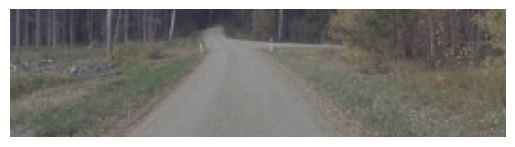

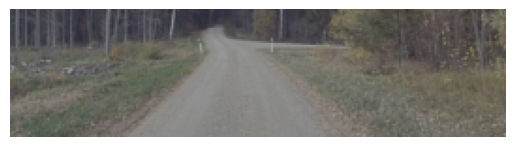

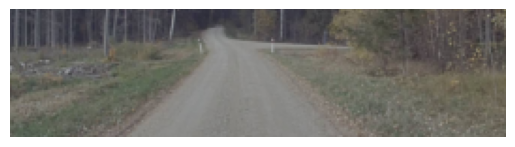

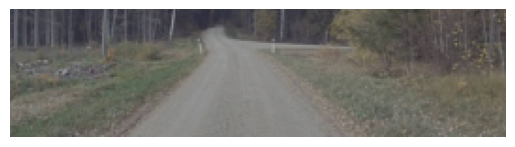

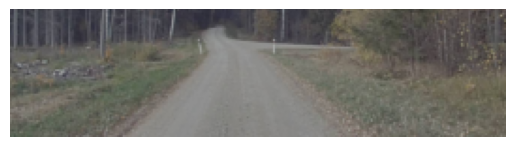

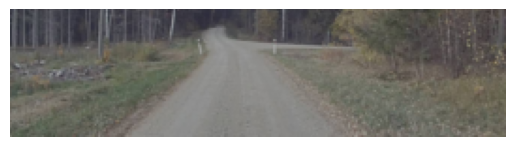

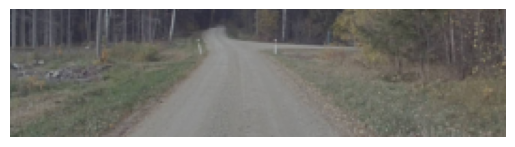

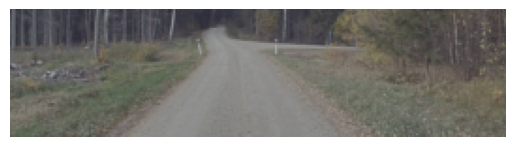

In [8]:
tens = next(iter(train_loader))[0]['image'][0]
for i in range(len(tens)):
    plt.imshow(tens[i].permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [17]:
LEARNING_RATE = 1e-3
DECAY = 1e-02
SAVE_DIR = Path('trained_models')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
criterion = L1Loss().to(device)
model = PerceiverRNN(pmodel, steering_classifier).to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=LEARNING_RATE,
                              betas=(0.9, 0.999),
                              eps=1e-08,
                              weight_decay=DECAY,
                              amsgrad=False)

Using device: cuda


In [20]:
def calculate_whiteness(steering_angles, fps):
    current_angles = steering_angles[:-1]
    next_angles = steering_angles[1:]
    delta_angles = next_angles - current_angles

    whiteness = np.sqrt(((delta_angles * fps) ** 2).mean())
    return whiteness

def calculate_open_loop_metrics(predicted_steering, true_steering, fps):
    predicted_degrees = predicted_steering / np.pi * 180
    true_degrees = true_steering / np.pi * 180

    somewhere_middle = len(predicted_degrees) // 2

    errors_signed = predicted_degrees - true_degrees # positive means error to the left
    errors = np.abs(errors_signed)
    whiteness = calculate_whiteness(predicted_degrees, fps)
    expert_whiteness = calculate_whiteness(true_degrees, fps)

    return {
        'mae': errors.mean(),
        'rmse': np.sqrt((errors ** 2).mean()),
        'bias': errors_signed.mean(),
        'max': errors.max(),
        'whiteness': whiteness,
        'expert_whiteness': expert_whiteness
    }

def calculate_metrics(fps, predictions, valid_loader):
        frames_df = valid_loader.dataset.frames

        true_steering_angles = frames_df.steering_angle.to_numpy()
        metrics = calculate_open_loop_metrics(predictions, true_steering_angles, fps=fps)

        left_turns = frames_df["turn_signal"] == 0
        if left_turns.any():
            left_metrics = calculate_open_loop_metrics(predictions[left_turns], true_steering_angles[left_turns], fps=fps)
            metrics["left_mae"] = left_metrics["mae"]
        else:
            metrics["left_mae"] = 0

        straight = frames_df["turn_signal"] == 1
        if straight.any():
            straight_metrics = calculate_open_loop_metrics(predictions[straight], true_steering_angles[straight], fps=fps)
            metrics["straight_mae"] = straight_metrics["mae"]
        else:
            metrics["straight_mae"] = 0

        right_turns = frames_df["turn_signal"] == 2
        if right_turns.any():
            right_metrics = calculate_open_loop_metrics(predictions[right_turns], true_steering_angles[right_turns], fps=fps)
            metrics["right_mae"] = right_metrics["mae"]
        else:
            metrics["right_mae"] = 0

        return metrics

In [18]:
def train_epoch(model, loader, optimizer, criterion, progress_bar, epoch):
    running_loss = 0.0
    model.train()

    for i, (data, target_values, condition_mask) in enumerate(loader):
        optimizer.zero_grad()

        inputs = data['image'].to(device) # (T, B, H, W, C)
        target_values = target_values.to(device) # (T, B)
        
        latents = None
        total_loss = 0.0
        
        for t in range(inputs.size(0)):
            input_frame = inputs[t]
            target_frame = target_values[t]

            predictions, latents = model(input_frame, latents)

            # Calculate loss for the current time step
            loss = criterion(predictions.squeeze(), target_frame)
            loss.backward(retain_graph=True if t < inputs.size(0) - 1 else False)
            
            total_loss += loss

        optimizer.step()
        running_loss += total_loss.item()

        progress_bar.update(1)
        pbar_description = f'epoch {epoch+1} | train loss: {(running_loss / (i + 1)):.4f}'
        progress_bar.set_description(pbar_description)

    avg_loss = running_loss / len(loader)

    return avg_loss

In [19]:
def evaluate(model, loader, criterion, progress_bar, epoch, train_loss):
        epoch_loss = 0.0
        model.eval()
        all_predictions = []

        with torch.no_grad():
            for i, (data, target_values, condition_mask) in enumerate(loader):
                inputs = data['image'].to(device)
                target_values = target_values.to(device)
                
                latents = None
                sequence_predictions = []
                
                for t in range(inputs.size(0)):
                    input_frame = inputs[t]
                    target_frame = target_values[t]

                    predictions, latents = model(input_frame, latents)
                    sequence_predictions.append(predictions)

                    loss = criterion(predictions.squeeze(), target_frame)
                    epoch_loss += loss.item()
                
                all_predictions.extend(torch.stack(sequence_predictions).cpu().squeeze().numpy())

                progress_bar.update(1)
                progress_bar.set_description(f'epoch {epoch + 1} | train loss: {train_loss:.4f} | valid loss: {(epoch_loss / (i + 1)):.4f}')

        total_loss = epoch_loss / len(loader)
        result = np.array(all_predictions)
        return total_loss, result

In [ ]:
def train(train_loader, valid_loader, n_epoch, patience=10, fps=30, load_checkpoint=False):
    CHECKPOINT_FILENAME="checkpoint-2.pth.tar"
    
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
    
    if not load_checkpoint:
        best_valid_loss = float('inf')
        epochs_of_no_improve = 0
        epochs_passed = 0
        train_loss_list = []
        valid_loss_list = []
    else:
        checkpoint = torch.load(SAVE_DIR / CHECKPOINT_FILENAME)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        epochs_passed = checkpoint['epoch']
        best_valid_loss = checkpoint['best_valid_loss']
        epochs_of_no_improve = checkpoint['epochs_of_no_improve']
        train_loss_list = checkpoint['train_loss_list']
        valid_loss_list = checkpoint['valid_loss_list']

    if wandb_logging:
        wandb.watch(model, criterion)

    for epoch in range(n_epoch - epochs_passed):
        
        progress_bar = tqdm(total=len(train_loader), smoothing=0)
        train_loss = train_epoch(model, train_loader, optimizer, criterion, progress_bar, epoch)
        train_loss_list.append(train_loss)

        progress_bar.reset(total=len(valid_loader))
        valid_loss, predictions = evaluate(model, valid_loader, criterion, progress_bar, epoch, train_loss)
        valid_loss_list.append(valid_loss)

        scheduler.step(valid_loss)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            
            torch.save(model.state_dict(), SAVE_DIR / f"best.pt")
            
            epochs_of_no_improve = 0
            best_loss_marker = '*'
        else:
            epochs_of_no_improve += 1
            best_loss_marker = ''

        torch.save({
            'epoch': epoch + epoch_passed + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_valid_loss': best_valid_loss,
            'epochs_of_no_improve': epochs_of_no_improve,
            'train_loss_list': train_loss_list,
            'valid_loss_list': valid_loss_list
        }, SAVE_DIR / f"checkpoint-{epoch+epochs_passed}.pth.tar")
            
        metrics = calculate_metrics(fps, predictions, valid_loader)
        whiteness = metrics['whiteness']
        mae = metrics['mae']
        left_mae = metrics['left_mae']
        straight_mae = metrics['straight_mae']
        right_mae = metrics['right_mae']
        progress_bar.set_description(f'{best_loss_marker}epoch {epoch + 1}'
                                        f' | train loss: {train_loss:.4f}'
                                        f' | valid loss: {valid_loss:.4f}'
                                        f' | whiteness: {whiteness:.4f}'
                                        f' | mae: {mae:.4f}'
                                        f' | l_mae: {left_mae:.4f}'
                                        f' | s_mae: {straight_mae:.4f}'
                                        f' | r_mae: {right_mae:.4f}')

        if wandb_logging:
            metrics['epoch'] = epoch + 1
            metrics['train_loss'] = train_loss
            metrics['valid_loss'] = valid_loss
            wandb.log(metrics)

        if epochs_of_no_improve == patience:
            print(f'Early stopping, on epoch: {epoch + 1}.')
            break

    torch.save(model.state_dict(), SAVE_DIR / "last.pt")
    pt_models = [f'{SAVE_DIR}/last.pt', f'{SAVE_DIR}/best.pt']

    for pt_model_path in pt_models:
        model_path = convert_pt_to_onnx(pt_model_path)

    return best_valid_loss, train_loss_list, valid_loss_list

# Testing SRunner

In [1]:
import argparse
import sys
import logging
import random
import os
import wandb

from pathlib import Path
from models.pilotnet import PilotNet
from models.perciever import Perceiver
from models.perciever_rnn import MLPPredictor, PerceiverRNN
from train.trainer import PerceiverTrainer, PilotNetTrainer
from torch.nn import MSELoss, L1Loss
from torch.optim import AdamW
from torch.utils.data import DataLoader
from data_prep.nvidia import NvidiaDataset, NvidiaDatasetRNN
from experiment import *

/gpfs/space/home/okuu/rally-challenge-24/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class TrainingConfig:
    def __init__(self, args):
        self.model_type = args['model_type']
        self.model_name = args['model_name']
        self.loss = args['loss']
        self.dataset_folder = args['dataset_folder']
        self.seed = args['seed']
        self.batch_size = args['batch_size']
        self.num_workers = args['num_workers']
        self.weight_decay = args['weight_decay']
        self.learning_rate = args['learning_rate']
        self.learning_rate_patience = args['learning_rate_patience']
        self.wandb_project = args['wandb_project']
        self.max_epochs = args['max_epochs']
        self.patience = args['patience']
        self.seq_length = args['seq_length']
        self.stride = args['stride']
        self.fps = args['fps']

args = {
    'model_type' : 'perceiver',
    'model_name' : 'test',
    'loss' : 'mae',
    'dataset_folder' : '/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias',
    'seed' : 0,
    'batch_size' : 32,
    'num_workers' : 2,
    'weight_decay' : 1e-02,
    'learning_rate' : 1e-3,
    'learning_rate_patience' : 2,
    'wandb_project' : "wandb-test-project",
    'max_epochs' : 10,
    'patience' : 10,
    'seq_length' : 8,
    'stride' : 4,
    'fps' : 30
}

config = TrainingConfig(args)
if config.wandb_project:
    wandb.init(project=config.wandb_project, config={
        "model_name": config.model_name,
        "batch_size": config.batch_size,
        "learning_rate": config.learning_rate,
        "weight_decay": config.weight_decay,
    })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: filipp-petuhhov (ut-okuu). Use `wandb login --relogin` to force relogin


In [3]:
if config.model_type == "pilotnet":
    model = PilotNet()
    trainer = PilotNetTrainer(config.model_name, wandb_project=config.wandb_project)
elif config.model_type == "perceiver":
    pmodel = Perceiver(
        input_channels = 3,          # number of channels for each token of the input
        input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
        num_freq_bands = 6,          # number of freq bands, with original value (2 * K + 1)
        max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
        depth = 1,                   # depth of net. The shape of the final attention mechanism will be:
                                     #   depth * (cross attention -> self_per_cross_attn * self attention)
        num_latents = 256,           # number of latents, or induced set points, or centroids. different papers giving it different names
        latent_dim = 512,            # latent dimension
        cross_heads = 1,             # number of heads for cross attention. paper said 1
        latent_heads = 8,            # number of heads for latent self attention, 8
        cross_dim_head = 64,         # number of dimensions per cross attention head
        latent_dim_head = 64,        # number of dimensions per latent self attention head
        num_classes = 1,          # output numb"er of classes
        attn_dropout = 0.,
        ff_dropout = 0.,
        weight_tie_layers = False,   # whether to weight tie layers (optional, as indicated in the diagram)
        fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
        self_per_cross_attn = 2      # number of self attention blocks per cross attention
    )
    steering_classifier = MLPPredictor(512, 64)

    model = PerceiverRNN(pmodel, steering_classifier)
    trainer = PerceiverTrainer(config.model_name, wandb_project=config.wandb_project)
else:
    logging.error("Unknown model type: %s", config.model_type)
    sys.exit()

criterion = get_loss_function(config)
optimizer = AdamW(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.999),
                              eps=1e-08, weight_decay=config.weight_decay, amsgrad=False)

train_loader, valid_loader = load_data(config)

[NvidiaDataset] Using transform from argument: Compose(
)
/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias/2021-05-28-15-07-56_e2e_sulaoja_20_30: length=15626, filtered=0
/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias/2021-06-09-16-24-59_e2e_rec_ss13: length=34425, filtered=0
/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias/2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back: length=26763, filtered=0
[NvidiaDataset] Using transform from argument: Compose(
)
/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias/2021-05-28-15-19-48_e2e_sulaoja_20_30: length=10708, filtered=0


In [4]:
trainer.train(model, config.model_type, train_loader, valid_loader, optimizer, criterion,
              config.max_epochs, config.patience, config.learning_rate_patience, config.fps)

epoch 1 | train loss: 3.5383 | valid loss: 2.7942: 100%|██████████| 84/84 [00:52<00:00,  1.61it/s]

Preds: torch.Size([20]); target: torch.Size([20])
Preds: torch.Size([20]); target: torch.Size([20])
Preds: torch.Size([20]); target: torch.Size([20])
Preds: torch.Size([20]); target: torch.Size([20])
Preds: torch.Size([20]); target: torch.Size([20])
Preds: torch.Size([20]); target: torch.Size([20])
Preds: torch.Size([20]); target: torch.Size([20])
Preds: torch.Size([20]); target: torch.Size([20])


*epoch 1 | train loss: 3.5383 | valid loss: 2.7942 | whiteness: 0.0000 | mae: 20.0456 | l_mae: 0.0000 | s_mae: 14.2708 | r_mae: 117.9847: 100%|██████████| 84/84 [00:52<00:00,  1.60it/s]/gpfs/space/home/okuu/rally-challenge-24/venv/lib/python3.8/site-packages/torch/onnx/utils.py:1702: UserWarning: The exported ONNX model failed ONNX shape inference. The model will not be executable by the ONNX Runtime. If this is unintended and you believe there is a bug, please report an issue at https://github.com/pytorch/pytorch/issues. Error reported by strict ONNX shape inference: [ShapeInferenceError] (op_type:LayerNormalization, node name: /layers.0.0/norm_context/LayerNormalization): Scale has inconsistent type tensor(float) (Triggered internally at ../torch/csrc/jit/serialization/export.cpp:1488.)
  _C._check_onnx_proto(proto)
*epoch 1 | train loss: 3.5383 | valid loss: 2.7942 | whiteness: 0.0000 | mae: 20.0456 | l_mae: 0.0000 | s_mae: 14.2708 | r_mae: 117.9847: 100%|██████████| 84/84 [01:07<00

2.794244670747026

In [10]:
import logging
import sys
from abc import abstractmethod
from datetime import datetime
from pathlib import Path
from einops import rearrange
import numpy as np
import onnx
import torch
from torch.nn import functional as F
import wandb
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm

from metrics.metrics import calculate_open_loop_metrics

# model.load_state_dict(torch.load(f"{trainer.save_dir}/best.pt"))
# model.to(trainer.device)

# #data = iter(valid_loader).next()
# #Update to fix an issue of deprecated code.
# data = iter(valid_loader)
# data = next(data)
# sample_inputs = trainer.create_onxx_input(data)
# torch.onnx.export(model, sample_inputs, f"{trainer.save_dir}/best.onnx")
# onnx.checker.check_model(f"{trainer.save_dir}/best.onnx")
# #Remove batch size from the input/output
# m = onnx.load(f"{trainer.save_dir}/best.onnx")
# m.graph.input[0].type.tensor_type.shape.dim[0].dim_value = 1
# m.graph.output[0].type.tensor_type.shape.dim[0].dim_value =1
# onnx.save(m,f"{trainer.save_dir}/best.onnx")

# if trainer.wandb_logging:
#     wandb.save(f"{trainer.save_dir}/best.onnx")

model.load_state_dict(torch.load(f"{trainer.save_dir}/last.pt"))
model.to(trainer.device)

torch.onnx.export(model, sample_inputs, f"{trainer.save_dir}/last.onnx")
onnx.checker.check_model(f"{trainer.save_dir}/last.onnx")
# if trainer.wandb_logging:
#     wandb.save(f"{trainer.save_dir}/last.onnx")

In [7]:
sample_inputs.shape

torch.Size([32, 68, 264, 3])